Files already downloaded
Files already downloaded


..\ConvexNN\train.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 5)


[1/100] train loss: 5622.5821533203125 test loss: 3085.466168212891
[2/100] train loss: 2228.552001953125 test loss: nan
[3/100] train loss: 1376.9917449951172 test loss: nan
[4/100] train loss: 1013.8014541625977 test loss: nan
[5/100] train loss: 814.9193710327148 test loss: nan
[6/100] train loss: 690.7811279296875 test loss: nan
[7/100] train loss: 603.2939254760743 test loss: nan
[8/100] train loss: 540.5933181762696 test loss: nan
[9/100] train loss: 492.1512710571289 test loss: nan
[10/100] train loss: 455.37619705200194 test loss: nan
[11/100] train loss: 423.59528121948244 test loss: 526.1307899475098
[12/100] train loss: 399.0575881958008 test loss: nan
[13/100] train loss: 380.0192588806152 test loss: nan
[14/100] train loss: 362.3276611328125 test loss: nan
[15/100] train loss: 348.25713577270506 test loss: nan
[16/100] train loss: 336.11211547851565 test loss: nan
[17/100] train loss: 325.6975212097168 test loss: nan
[18/100] train loss: 317.9638786315918 test loss: nan
[1

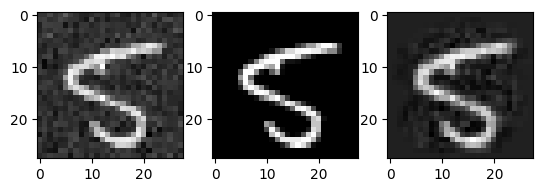

314.5770950317383


In [1]:
import sys
sys.path.append("..")
import numpy as np
from sklearn import svm, metrics
import matplotlib.pyplot as plt
import torchvision
from Noisy_MNIST import NoisyMNIST
from ConvexNN.factory import generate_model

model, train_dataset, test_dataset = generate_model(8000, 28 * 28, 100, 1e-4, None, learning_rate=1e-5,
                   batch_size=25, rho=1, device='cuda')

In [2]:
train_images = []
train_labels = []
for _, image, label in train_dataset:
    train_images.append(image.detach().numpy())
    train_labels.append(label.item())

test_images = []
test_labels = []
for _, image, label in test_dataset:
    test_images.append(image.detach().numpy())
    test_labels.append(label.item())
train_images = np.asarray(train_images)
train_labels = np.asarray(train_labels)
test_labels = np.asarray(test_labels)
test_images = np.asarray(test_images)
train_images.shape, test_images.shape

((1000, 784), (1000, 784))

In [3]:
model_linear = svm.SVC(kernel='linear')
model_linear.fit(train_images, train_labels)

SVC(kernel='linear')

In [4]:
y_pred = model_linear.predict(test_images)
np.sum(y_pred == test_labels) / len(test_labels)

0.876

In [5]:
from torch.utils.data import DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=25, shuffle=False)

In [6]:
import torch
from torch.autograd import Variable
device = torch.device('cuda')
confusion_matrix = np.zeros((2, 2))
with torch.no_grad():
    for noisy_image, base_image, label in test_dataloader:
        noisy_image = Variable(noisy_image).to(device)
        denoised_image = model(noisy_image)
        denoised_image = denoised_image.view(denoised_image.shape[0], -1)
        
        base_image = base_image.view(base_image.shape[0], -1)
        base_image = base_image.detach().cpu().numpy()
        
        prediction_denoised = model_linear.predict(denoised_image.detach().cpu().numpy())
        prediction_baseImage = model_linear.predict(base_image)
        label = label.detach().cpu().numpy()
        
        correct_base = prediction_baseImage == label
        
        confusion_matrix[0, 0] += np.sum(prediction_denoised[correct_base] == label[correct_base])
        confusion_matrix[0, 1] += np.sum(prediction_denoised[correct_base] != label[correct_base])
        confusion_matrix[1, 0] += np.sum(prediction_denoised[~correct_base] == label[~correct_base])
        confusion_matrix[1, 1] += np.sum(prediction_denoised[~correct_base] != label[~correct_base])
        
        correct += np.sum(prediction == label)
print(confusion_matrix / len(test_dataset))

NameError: name 'correct' is not defined

In [ ]:
np.sum(confusion_matrix)

In [ ]:
import seaborn as sns

In [ ]:
ax = sns.heatmap(confusion_matrix / 1000, annot=True, fmt='.2%', xticklabels=["Correct", "Incorrect"],
            yticklabels=['Correct', "Incorrect"])
ax.set(xlabel="Denoised Prediction", ylabel="BaseImage Prediction")